In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np

In [2]:
# Prepare data
pv_generation = (
    pd.read_csv("./data/solar_prod.csv", parse_dates=["utc_timestamp"])  
    .rename(columns={"utc_timestamp": "time", "AT_solar_generation_actual": "pv_gen"})             
    .drop(columns=["cet_cest_timestamp"])                  
    .assign(                                               
        year=lambda df: df["time"].dt.year,
        day_of_year=lambda df: df["time"].dt.day_of_year
    )
    .dropna()                                              
)

pv_generation.head()

,time,pv_gen,year,day_of_year
8,2015-01-01 07:00:00+00:00,2.0,2015,1
9,2015-01-01 08:00:00+00:00,10.0,2015,1
10,2015-01-01 09:00:00+00:00,21.0,2015,1
11,2015-01-01 10:00:00+00:00,32.0,2015,1
12,2015-01-01 11:00:00+00:00,37.0,2015,1


In [3]:
weather_data = (
    pd.read_csv("./data/weather_data.csv", parse_dates=["utc_timestamp"])
    .rename(columns={"utc_timestamp": "time", "AT_temperature": "tt", "AT_radiation_diffuse_horizontal": "rad_diffuse"})
    .drop(columns=["AT_radiation_direct_horizontal"])
    .dropna()
)
weather_data.head()

,time,tt,rad_diffuse
0,2015-01-01 00:00:00+00:00,-6.503,0.0
1,2015-01-01 01:00:00+00:00,-6.458,0.0
2,2015-01-01 02:00:00+00:00,-6.253,0.0
3,2015-01-01 03:00:00+00:00,-5.908,0.0
4,2015-01-01 04:00:00+00:00,-5.516,0.0


Text(0.5, 1.0, 'Solar power production')

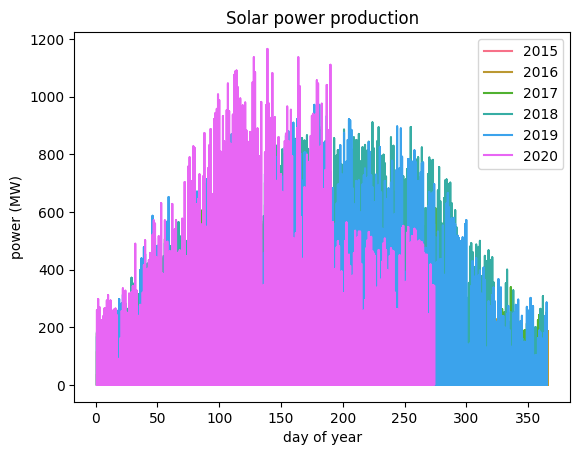

In [4]:
unique_years = pv_generation["year"].unique()

color = sns.color_palette("husl", n_colors=len(unique_years))
color_map = dict(zip(unique_years, color))

fig, ax = plt.subplots()
for year in pv_generation.groupby(pv_generation["time"].dt.year):
    year, year_df = year
    year_df.plot(x="day_of_year",
                 y="pv_gen",
                 ax=ax,
                 label=str(year),
                 color=color_map[year])
ax.set_xlabel("day of year")
ax.set_ylabel("power (MW)")
ax.set_title("Solar power production")

We can see the gradual increase in solar power production. Although, the tail of 2020's data is unsual (due to COVID ?).

In [5]:
# Creation of dataset for prediction
# Using weather data as a weather prediction 2 hours ahead
forecast_table = (pv_generation[["time", "pv_gen"]]
                  .merge(
                    weather_data[["time", "tt", "rad_diffuse"]], 
                    on="time", 
                    how="inner")
                .assign(    
                    hour=lambda df: df["time"].dt.hour,                                           
                    year=lambda df: df["time"].dt.year,
                    day_of_year=lambda df: df["time"].dt.day_of_year
    )
)

# Shift weather data by -2 hours to create +2h forecast
# At time t, weather_data at t+2 becomes the "forecast"
forecast_table["tt+2h"] = forecast_table["tt"].shift(-2)
forecast_table["irr+2h"] = forecast_table["rad_diffuse"].shift(-2)
forecast_table["pv_gen_t+2h"] = forecast_table["pv_gen"].shift(-2)

forecast_table = forecast_table[["time", "hour", "year", "day_of_year", "pv_gen", "tt+2h", "irr+2h", "pv_gen_t+2h"]]

# Filter end date if needed
end_date = pd.to_datetime("2024-01-05").tz_localize("UTC")
forecast_table = forecast_table[forecast_table["time"] <= end_date]

forecast_table = forecast_table.dropna()

correlation_gen_irr2H = forecast_table["pv_gen_t+2h"].corr(forecast_table["irr+2h"])
print("Pearson correlation forecasting +2 hour: ", correlation_gen_irr2H)

forecast_table.head(15)

Pearson correlation forecasting +2 hour:  0.7348217941289484


,time,hour,year,day_of_year,pv_gen,tt+2h,irr+2h,pv_gen_t+2h
0,2015-01-01 07:00:00+00:00,7,2015,1,2.0,-1.315,116.917108,21.0
1,2015-01-01 08:00:00+00:00,8,2015,1,10.0,-0.051,146.892313,32.0
2,2015-01-01 09:00:00+00:00,9,2015,1,21.0,0.791,151.472136,37.0
3,2015-01-01 10:00:00+00:00,10,2015,1,32.0,1.234,131.958607,35.0
4,2015-01-01 11:00:00+00:00,11,2015,1,37.0,1.186,95.505586,27.0
5,2015-01-01 12:00:00+00:00,12,2015,1,35.0,0.460,38.615260,14.0
6,2015-01-01 13:00:00+00:00,13,2015,1,27.0,-0.586,1.314699,3.0
7,2015-01-01 14:00:00+00:00,14,2015,1,14.0,-1.445,0.000000,0.0
8,2015-01-01 15:00:00+00:00,15,2015,1,3.0,-1.879,0.000000,0.0
9,2015-01-01 16:00:00+00:00,16,2015,1,0.0,-2.239,0.000000,0.0


In [6]:
def run_walk_forward_cv(df, features, target_col="pv_gen_t+2h", train_window=8760, test_window=720):
    """
    Runs a walking forward validation.
    train_window: 8760 hours (1 year)
    test_window: 720 hours (~1 month)
    """
    X = df[features]
    y = df[target_col]
    
    global_cap = y.max() # For NRMSE normalization
    
    errors_rmse = []
    errors_nrmse = []
    
    # Step size equals test window (sliding non-overlapping chunks)
    # Start loop after the first year of data
    total_len = len(df)
    
    print(f"Starting CV with {len(features)} features: {features}")
    
    for i in range(train_window, total_len - test_window + 1, test_window):
        
        idx_train_end = i
        idx_test_end = i + test_window
        
        X_train, y_train = X.iloc[:idx_train_end], y.iloc[:idx_train_end]
        X_test, y_test = X.iloc[idx_train_end:idx_test_end], y.iloc[idx_train_end:idx_test_end]
        
        model = xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=6,
            early_stopping_rounds=50,
            n_jobs=-1,
            random_state=42
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False
        )
        
        preds = model.predict(X_test)
        preds = np.maximum(preds, 0)
        
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        nrmse = (rmse / global_cap) * 100
        
        errors_rmse.append(rmse)
        errors_nrmse.append(nrmse)
        
    avg_rmse = np.mean(errors_rmse)
    avg_nrmse = np.mean(errors_nrmse)
    
    print(f"Done. Avg RMSE: {avg_rmse:.2f} MW | Avg NRMSE: {avg_nrmse:.2f}%")
    return avg_nrmse

In [7]:
cols_base = ["hour", "day_of_year", "pv_gen"]
score_base = run_walk_forward_cv(forecast_table, cols_base)

cols_weather = ["hour", "day_of_year", "pv_gen", "tt+2h", "irr+2h"]
score_weather = run_walk_forward_cv(forecast_table, cols_weather)

print("\n--- Results ---")
print(f"Baseline: {score_base:.2f}%")
print(f"Weather:  {score_weather:.2f}%")

Starting CV with 3 features: ['hour', 'day_of_year', 'pv_gen']
Done. Avg RMSE: 21.46 MW | Avg NRMSE: 2.20%
Starting CV with 5 features: ['hour', 'day_of_year', 'pv_gen', 'tt+2h', 'irr+2h']
Done. Avg RMSE: 22.27 MW | Avg NRMSE: 2.28%

--- Results ---
Baseline: 2.20%
Weather:  2.28%


#### Conclusion

**Baseline & Data Limitations**
We established a baseline error of 2.20% for country-wide solar production. The investigation indicates that aggregated weather data (population-mean) lacks predictive power because solar capacity is not distributed according to population density.

**Improvement**
Introduction **Solar Elevation** and **Solar Azimuth** measure, which can be computed, could probably help the model achieve better prediction.

* **Elevation** defines the physical maximum power ceiling (forcing zero output at night).
* **Azimuth** provides the necessary context to distinguish morning from afternoon. 

The primary improvement lies in replacing national aggregates with **fine-grained weather forecasts**. Moving to a spatial grid forecast allows the model to weight weather conditions based on the actual density of installed PV capacity, rather than population centers. This would also require a pricese knowledge of installed PV capacity.